In [ ]:
'''Мы проведем  Т-тест, Мана Уитни, Пуассоновский бутстрап, а также бакетное преобразование и сглаживание метрики'''

In [1]:
# Импорт необходимых библиотек для визаулизации, тестов, и сбора данных из ClickHouse
import seaborn as sns
from scipy import stats
import pandahouse as ph
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Соединяемся с кликхаус и запрашиваем данные с 2025-01-03 по 2025-01-09
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20250120',
    'user':'student',
    'password':'dpo_python_2020'}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) <= toDate('2025-01-09')
    and exp_group in (2,1)
GROUP BY exp_group, user_id
"""
# Запрос исходной таблицы из БД для понимания структуры таблицы
q_table = """
SELECT *
FROM {db}.feed_actions 
WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) <= toDate('2025-01-04')"""

In [3]:
# Наша исходная таблица со всеми данными по каждому пользователю и группой exp_group
df_table = ph.read_clickhouse(q_table, connection=connection)
df_table.head(5)

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,123767,2040,view,2025-01-04 20:06:53,1,21,Russia,Samara,Android,organic,1
1,129655,2116,view,2025-01-04 20:06:53,0,26,Russia,Saint Petersburg,iOS,organic,4
2,131026,2095,view,2025-01-04 20:06:53,1,22,Russia,Moscow,Android,organic,4
3,28786,2167,view,2025-01-04 20:06:54,1,16,Russia,Moscow,iOS,ads,2
4,131026,2048,view,2025-01-04 20:06:54,1,22,Russia,Moscow,Android,organic,4


In [4]:
# Смотрим размер выборок должен быть примерно одиноковый
df = ph.read_clickhouse(q, connection=connection)
df.groupby('exp_group')['user_id'].count()

exp_group
1    10020
2     9877
Name: user_id, dtype: int64

In [4]:
# Посмотрим размер среднего CTR в выборках
df.groupby('exp_group')['ctr'].mean()

exp_group
1    0.216774
2    0.216102
Name: ctr, dtype: float64

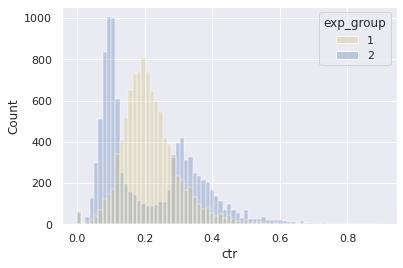

In [3]:
# Посмотрим на распределения CTR визуально
sns.set(rc={'figure.figsize':(11,5)})

sns.histplot(data = df, x='ctr', hue='exp_group', palette = ['y', 'b'], alpha=0.3, kde=False)

# Распределение признака 2 группы имеет два характерных максимума
# при этом средние в группах различаются незначительно

In [7]:
# Посмотрим что датет проверка на нормальность теста Колмогорова- Смирнова
stat1, p1 = stats.kstest(df[df.exp_group == 1].ctr,'norm')
stat2, p2 = stats.kstest(df[df.exp_group == 2].ctr,'norm')
print(f'Для группы 1: Statistic = {stat2:.2f}, Pvalue = {p2:.2f}\n'
      f'Для группы 2: Statistic = {stat2:.2f}, Pvalue = {p2:.2f}')

# Нулевую гипотезу о нормальности распределения отклоняеем для обеих выборок

Для группы 1: Statistic = 0.51, Pvalue = 0.00
Для группы 2: Statistic = 0.51, Pvalue = 0.00
0.5124048076137383, 0.0


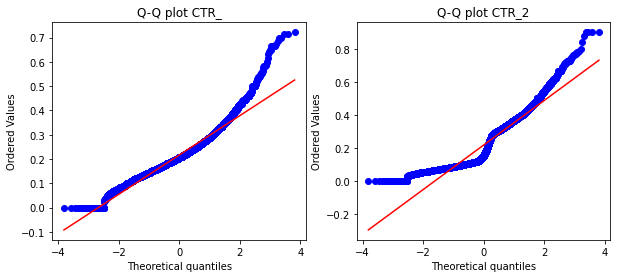

In [6]:
#  Q-Q plot для CTR_1
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
stats.probplot(df[df['exp_group'] == 1]['ctr'], dist="norm", plot=plt)
plt.title('Q-Q plot CTR_')

#  Q-Q plot для CTR_2
plt.subplot(1, 2, 2)
stats.probplot(df[df['exp_group'] == 2]['ctr'], dist="norm", plot=plt)
plt.title('Q-Q plot CTR_2')
plt.show()
# Судя по графикам наши выборки имеют отличное от нормального распределение
# для 1группы небольшие отклонения,а для группы 2 гараздо более выраженные отличия .

In [8]:
# Сравним дисперсии выборок тестом Левена для не нормальных распределений
stat, p = stats.levene(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr)
print(f'Statistic levene = {stat:.2f} Pvalue = {p_value:.2f}')

Statistic levene = 2757.79 Pvalue = 0.00


In [12]:
# Мы имеем распределения отклоненные от нормальных и не равные дисперсии
# Посмотрим что даст в таких условия Т-тест
stat_t, p_t = stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)
print(f'Statistic = {stat_t:.2f}, Pvalue = {p_t:.2f}')

Statistic = 0.41, Pvalue = 0.69


In [ ]:
Т-тест говорит об отсутствии значимых различий в выборках, но
поскольку данные имею сильные отклонения от нормальности - мы не будет доверять
этим данным, а проведем еще тесты.

In [27]:
# Мана-Уитни
# 'two-sided' различия вообще ,'less' первая выборка меньше, 'greater' первая выборка больше
stat_m, p_m = stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                  df[df.exp_group == 2].ctr,
                  alternative = 'two-sided')
stat_1, p_1 = stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                  df[df.exp_group == 2].ctr,
                  alternative = 'less')
print(f'two-sided Statistic = {stat_m:.2f}, Pvalue = {p_m:.2f}\n'
      f'less Statistic = {stat_1:.2f}, Pvalue = {p_1:.2f}')


two-sided Statistic = 55189913.00, Pvalue = 0.00
less Statistic = 55189913.00, Pvalue = 1.00


In [ ]:
Наш новый алгоритм во 2 группе должен был повысить CTR, и в таком случае 
распределение 1 было бы сдвинуто влево, но тест не дает значимых различий в этом направлении,
но говорит о различиях впринципе.

In [29]:
# Сверим количество раз когда CTR из 2 группы больше >чем с 1
N = 0
for _ in range(10000):
    N += df[df.exp_group == 2].ctr.sample().values[0] > df[df.exp_group == 1].ctr.sample().values[0]
    
print('В', N/100, '% случаев A > B. Должно получиться > 50% - если наш алгоритм работает')

В 44.5 % случаев A > B. Должно получиться > 50% - если наш алгоритм работает


In [ ]:
Как видим количество больших значений из 2 группы - не достаточно для того чтоб сказать
что наш алгоритм повышает CTR, а даже наоборот. Но учитывая вид распределения которое дает 2 группа
(с двумя максимумами), можно предположить что по какой-то причине пользователи в выборке были разбиты на две
группы причем у одной группы CTR стал вышекак мы  и ожидали, а у другой наоборот упал.

In [ ]:
'''
Проблема t-теста на пользовательском CTR в том, что у нас есть пользователи с небольшим количеством просмотров,
а их CTR сильно зашумлен.Давайте «сгладим» наши оценки CTR.
Идея проста: когда просмотров много, сглаженный CTR почти равен CTR пользователя. Когда просмотров мало, 
сглаженный CTR почти равен общегрупповому CTR. Иначе говоря, если у пользователя много просмотров, мы можем 
быть уверены, что клики / просмотры — хорошая оценка его CTR, а когда у пользователя просмотров мало, мы 
устанавливаем в качестве оценки общегрупповой CTR.'''

In [51]:
# Пробуем посчитать сглаженные CTR в группах
# возьмем умеренное значение alpha = 5
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
# Функция для расчета сглаженного CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

group_2 = df[df.exp_group == 2].copy()
group_1 = df[df.exp_group == 1].copy()             
    
group_2['smothed_ctr'] = group_2.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)
             
group_1['smothed_ctr'] = group_1.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

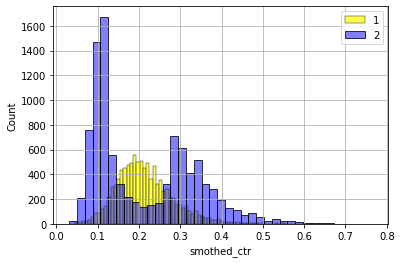

In [52]:
# Визуализация сглаженных CTR

sns.histplot(data=group_1, x=group_1.smothed_ctr, label='1', color='yellow', alpha=0.7)
sns.histplot(data=group_2, x=group_2.smothed_ctr, label='2', color='blue', alpha=0.5)
plt.grid()
plt.legend()

In [53]:
# Т-тест на сглаженных CTR
stat_t, p_t = stats.ttest_ind(group_2.smothed_ctr,
                group_1.smothed_ctr,
                equal_var=False) 
print(f' Smothed Statistic = {stat_t:.2f}, Pvalue = {p_t:.4f}')

 Smothed Statistic = -1.95, Pvalue = 0.0517


In [ ]:
После сглаживания Т-тест не дает стат значимых различий но уже не так очевидно как на не сглаженных данных

In [55]:
# Мана-Уитни на сглаженных CTR
stat_m, p_m = stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                  df[df.exp_group == 2].ctr,
                  alternative = 'two-sided')
stat_m1, p_m1 = stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                  df[df.exp_group == 2].ctr,
                  alternative = 'less')
print(f'two-sided Statistic = {stat_m:.2f}, Pvalue = {p_m:.2f}\n'
      f'less Statistic = {stat_m1:.2f}, Pvalue = {p_m1:.2f}')


two-sided Statistic = 55189913.00, Pvalue = 0.00
less Statistic = 55189913.00, Pvalue = 1.00


In [ ]:
Мана-Уитни на сглаженных CTR, дает аналогичные результаты как при обычных CTR.
Различия между группами есть - но точно не в сторону 2 группы, чаще
значения из 1 группы больше чем из второй

In [57]:
# Сверим количество раз когда CTR из 1группы больше чем во 2
N = 0
for _ in range(10000):
    N += group_1.smothed_ctr.sample().values[0] > group_2.smothed_ctr.sample().values[0]
    
print(f'В {N/100}% случаев 1гр > 2гр.')

В 56.92% случаев 1гр > 2гр.


In [ ]:
Чтоб посчитать разницу в CTR между группами можно многократно брать из каждой выборки, подвыборки с возвращением
считать в них CTR, и строить распределение таких CTR. Но можно считать сколько раз каждое конкретное наблюдение
попадет в выборку - такая величина будет иметь Биномиальное распределение (т.е. число успехов в n испытаниях,
в нашем примере число лайков при n просмотров свероятностью CTR)
CTR — это отношение, а не исходная величина. Его дисперсия зависит и от лайков, и от просмотров, поэтому просто CTR
мы не можем взять, а будем брать количество раз из Пуассоновского распределения - это будет  poisson_bootstraps
При большом числе испытаний распределение Биномиальное стремится к Пуассоновскому, которое работает быстрее.
Берем выборку из группы А (у нас это user\_iduser_id с его views и clicks)
Из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку»
Считаем «глобальный CTR» по псевдовыборке для A
Тоже самое считаем для гуппы В. После этого можно построить график распределения глобальных CTR,
или каждый раз брать разницу в CTR, и визуализировать ее.

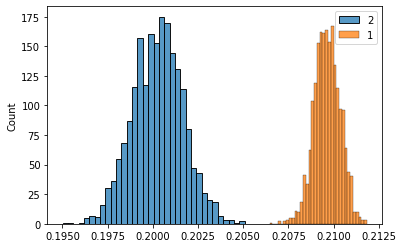

In [71]:
# Величина выборок достаточно велика (10000), вероятность попасть в выборку 1/10000
# в таком случае используем распределение Пуассона из которого будем генерить
# число раз попадания в выборку каждого конкретного значения
import numpy as np
likes2 = df[df.exp_group == 2].likes.to_numpy() # массив лайков
views2 = df[df.exp_group == 2].views.to_numpy() # массив просмотров
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
def bootstrap(likes2, views2, likes1, views1, n_bootstrap=2000):
    # матрица "n_bootstrap" на "len(likes2)" - число попаданий
    # в выборку, взятое из распр.Пуассона
    #  При λ < 1 элементы включались бы реже, уменьшая «эффективный» размер выборки.
    # При λ > 1 увеличилось бы число повторений, что исказило дисперсию.
    # При λ=1 каждый элемент включается в выборку в среднем 1 раз.
    poisson_bootstraps2 = stats.poisson(1).rvs(        
        (n_bootstrap, len(likes2))).astype(np.int64)   

    poisson_bootstraps1 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes1))).astype(np.int64)
    
    # каждое значение лайков множим на количество попаданий в выборку
    # и берем сумму по строке (axis=1) - получим количество в выборке/на кол-во просмотров 
    # на выходе получаем массив CTR
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)

    return globalCTR2, globalCTR1
ctr2, ctr1 = bootstrap(likes2, views2, likes1, views1)

sns.histplot(ctr2, label='2')
sns.histplot(ctr1, label='1')
plt.legend()

In [ ]:
Бутстрап не чувствительный к форме распределения дает вполне очевидные
различия в глобальных CTR примерно в 1%

In [7]:
# Бакетное преобразование - разбиение пользователей на 80 - групп(бакетов) случайным образом
# используя хеширование, и посчитаем CTR для каждой группы
q_backet = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
    
FROM (SELECT exp_group, 
        xxHash64(user_id)%80 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) <= toDate('2025-01-09')
        and exp_group in (2, 1)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
ORDER BY exp_group, bucket
"""
df_backet = ph.read_clickhouse(q_backet, connection=connection)
df_backet.head(3)

,exp_group,bucket,bucket_ctr
0,1,0,0.190529
1,1,1,0.208874
2,1,2,0.204165


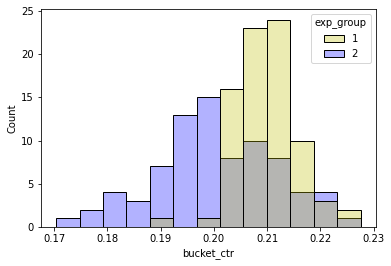

In [15]:
# Посмотрим на распределение бакетных CTR
sns.histplot(data=df_backet, x='bucket_ctr', hue='exp_group', palette = ['y', 'b'], alpha=0.3, kde=False)
plt.show()

In [ ]:
Отдаленно напоминает нормальное,и при этом, вырисовываются некие различия в группах

In [18]:
# Проверка на нормальность теста Колмогорова- Смирнова
stat1_ks, p1_ks = stats.kstest(df_backet[df_backet.exp_group == 1].bucket_ctr,'norm')
stat2_ks, p2_ks = stats.kstest(df_backet[df_backet.exp_group == 2].bucket_ctr,'norm')

print(f'Для группы 1: Statistic = {stat2_ks:.2f}, Pvalue = {p2_ks:.2f}\n'
      f'Для группы 2: Statistic = {stat2_ks:.2f}, Pvalue = {p2_ks:.2f}')
# Для обоих групп гипотезу о нормальности распределения - отклоняем

Для группы 1: Statistic = 0.57, Pvalue = 0.00
Для группы 2: Statistic = 0.57, Pvalue = 0.00


In [20]:
# Тест на равенство дисперсий- Levene
stat_lv, p_lv = stats.levene(df_backet[df_backet.exp_group == 1].bucket_ctr,
                             df_backet[df_backet.exp_group == 2].bucket_ctr)
print(f'Statistic = {stat_lv:.2f}, Pvalu = {p_lv:.2f}')

Statistic = 24.12, Pvalu = 0.00


In [22]:
# Т-тест на backet_CTR 
stat_bk, p_bk = stats.ttest_ind(df_backet[df_backet.exp_group == 2].bucket_ctr,
                df_backet[df_backet.exp_group == 1].bucket_ctr,
                equal_var=False) 
print(f'Bucket T test: Statistic = {stat_bk:.2f}, Pvalu = {p_bk:.2f}')

Bucket T test: Statistic = -6.47, Pvalu = 0.00


In [ ]:
Т-тест на бакетном преобразовании замечает различия между группами

In [24]:
# Мана-Уитни на backet_CTR
stat_mu1, p_mu1 = stats.mannwhitneyu(df_backet[df_backet.exp_group == 2].bucket_ctr,
                df_backet[df_backet.exp_group == 1].bucket_ctr,
                alternative = 'two-sided') 
stat_mu2, p_mu2 = stats.mannwhitneyu(df_backet[df_backet.exp_group == 1].bucket_ctr,
                df_backet[df_backet.exp_group == 2].bucket_ctr,
                alternative = 'less') 
print(f'two-sided Statistic = {stat_mu1:.2f}, Pvalue = {p_mu1:.2f}\n'
      f'less Statistic = {stat_mu2:.2f}, Pvalue = {p_mu2:.2f}')


two-sided Statistic = 1532.00, Pvalue = 0.00
less Statistic = 4868.00, Pvalue = 1.00


In [ ]:
Мана-Уитни дает теже результаты - стат значимые различия между выборками
и факт того что CTR во 2 группе НЕ стал больше чем в 1 группе, а скорее наоборот